# APMTH 207: Advanced Scientific Computing: 
## Stochastic Methods for Data Analysis, Inference and Optimization
## Homework #3
**Harvard University**<br/>
**Spring 2018**<br/>
**Instructors: Rahul Dave**<br/>
**Due Date: ** Friday, Febrary 16th, 2018 at 10:00am

**Instructions:**

- Upload your final answers as an iPython notebook containing all of your work to Canvas.

- Structure your notebook and your work to maximize readability.

In [1]:
import numpy as np
import pandas as pd
from copy import deepcopy
import time

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D

import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})
sns.set_context('talk')
%matplotlib inline

## Problem 1: Optimization via Descent

Suppose you are building a pricing model for laying down telecom cables over a geographical region. Your model takes as input a pair of  coordinates, $(x, y)$, and contains two parameters, $\lambda_1, \lambda_2$. Given a coordinate, $(x, y)$, and model parameters, the loss in revenue corresponding to the price model at location $(x, y)$ is described by
$$
L(x, y, \lambda_1, \lambda_2) = 0.000045\lambda_2^2 y - 0.000098\lambda_1^2 x + 0.003926\lambda_1 x\exp\left\{\left(y^2 - x^2\right)\left(\lambda_1^2 + \lambda_2^2\right)\right\}
$$
Read the data contained in `HW3_data.csv`. This is a set of coordinates configured on the curve $y^2 - x^2 = -0.1$. Given the data, find parameters $\lambda_1, \lambda_2$ that minimize the net loss over the entire dataset.

### Part A
- Visually verify that for $\lambda_1 = 2.05384, \lambda_2 = 0$, the loss function $L$ is minimized for the given data.
- Implement gradient descent for minimizing $L$ for the given data, using the learning rate of 0.001.
- Implement stochastic gradient descent for minimizing $L$ for the given data, using the learning rate of 0.001.

### Part B
- Compare the average time it takes to update the parameter estimation in each iteration of the two implementations. Which method is faster? Briefly explain why this result should be expected.
- Compare the number of iterations it takes for each algorithm to obtain an estimate accurate to `1e-3` (you may wish to set a cap for maximum number of iterations). Which method converges to the optimal point in fewer iterations? Briefly explain why this result should be expected.

### Part C
Compare the performance of stochastic gradient descent for the following learning rates: 1, 0.1, 0.001, 0.0001. Based on your observations, briefly describe the effect of the choice of learning rate on the performance of the algorithm.

### Answer to Problem 1 Part A

In [2]:
# Load data

data = np.genfromtxt('HW3_data.csv', delimiter=',')
x = data[0, ]
y = data[1, ]
print('Number of data points: {}.'.format(len(x)))

Number of data points: 16000.


In [3]:
# In GD, we use the gradient of total loss at each iteration
# In SGD, we multiply the gradient by total sample size at each iteration

# For the convenience of comparison, we compute the average loss
# when displaying / evaluating results

def L(x, y, lam):
    
    # Average loss   
    
    return np.mean(0.000045 * lam[1]**2 * y - 0.000098 * lam[0]**2 * x \
                 + 0.003926 * lam[0] * x * np.exp((y**2 - x**2) * (lam[0]**2 + lam[1]**2)))

def dL(x, y, lam):
    
    # Gradient of total loss
    
    z = y*y - x*x
    z1 = x*np.exp((lam[0]**2+lam[1]**2)*z)
    a = np.sum(-0.000196*lam[0]*x + (0.003926+0.007852*lam[0]**2*z)*z1)
    b = np.sum(0.00009*lam[1]*y + 0.007852*lam[0]*lam[1]*z*z1)
    return np.array([a, b])

#### Visually verify that for $\lambda_1 = 2.05384, \lambda_2 = 0$, the loss function $L$ is minimized for the given data.

We plot the point on 3D surface as well as the contour plot.

Average L(x, y, lambda_1=2.05384, lambda_2=0.0) = -0.0006208815015901337
Gradient is [ -4.53213012e-05   0.00000000e+00]


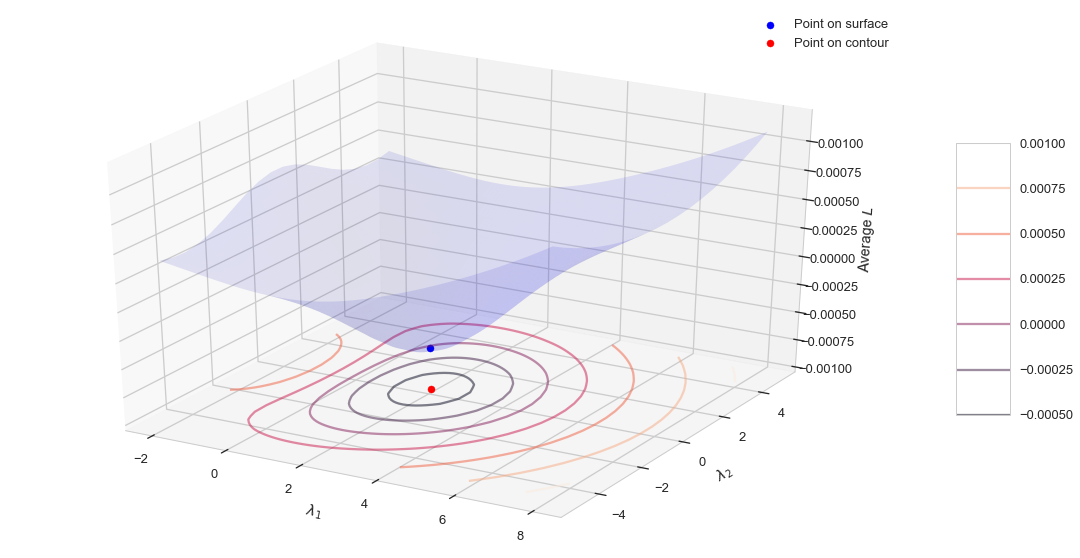

In [4]:
def plot_3d(ms=np.linspace(-2, 8, 100), bs = np.linspace(-5, 5, 20), z_offset=-1e-3, lam=None):
    
    # reference: 
    # https://am207.github.io/2018spring/wiki/gradientdescent.html
    
    M, B = np.meshgrid(ms, bs)
    zs = np.array([L(x, y, l) for l in zip(np.ravel(M), np.ravel(B))])
    Z = zs.reshape(M.shape)
    fig = plt.figure(figsize=(20, 10))
    ax = fig.gca(projection='3d')
    
    ax.plot_surface(M, B, Z, rstride=1, cstride=1, color='b', alpha=0.1)
    c = ax.contour(M, B, Z, alpha=0.5, offset=z_offset, stride=30)
    
    ax.set_zlim(z_offset, np.max(Z) * 1.1)
    ax.set_xlabel('$\lambda_1$', labelpad=15)
    ax.set_ylabel('$\lambda_2$', labelpad=15)
    ax.set_zlabel('Average $L$', labelpad=15)
    
    fig.colorbar(c, shrink=0.5, aspect=5)
    
    if lam is not None:
        ax.scatter([lam[0]], [lam[1]], [L(x, y, lam)], c='b', s=50, label='Point on surface')
        ax.scatter([lam[0]], [lam[1]], [z_offset], c='r', s=50, label='Point on contour')
        plt.legend()

lam_best = np.array([2.05384, 0])
print('Average L(x, y, lambda_1={}, lambda_2={}) = {}'.format(lam_best[0], lam_best[1], L(x, y, lam_best)))
print('Gradient is {}'.format(dL(x, y, lam_best)))
plot_3d(lam=lam_best)

From the visual check above, we know for $\lambda_1 = 2.05384, \lambda_2 = 0$, the loss function $L$ is minimized for the given data.

#### Implement gradient descent for minimizing $L$ for the given data, using the learning rate of 0.001.

In [5]:
class GD:
    def __init__(self, x, y, lam_init, step=0.001, max_iter=10000, tol=0.001):
        self.x = deepcopy(x)
        self.y = deepcopy(y)
        self.m = x.size
        self.lam_init = lam_init
        self.step = step
        self.max_iter = max_iter
        self.tol = tol
        self.costs = []
        self.time_ = []
        self.total_time = 0
        self.history = []
        self.iter_ = 0
        
    def run_gd(self):
        
        # Run max_iter iterations
        
        total_start = time.time()
        self.history.append(self.lam_init)
        self.costs.append(L(self.x, self.y, self.lam_init))
        for _ in range(self.max_iter):
            start = time.time()
            self.iter_ += 1
            self.history.append(self.history[-1] - self.step * dL(self.x, self.y, self.history[-1]))
            self.costs.append(L(self.x, self.y, self.history[-1]))
            self.time_.append(time.time() - start)
        self.total_time = time.time() - total_start
        return self
    
    def run_gd_test(self, actual=np.array([2.05384, 0])):
        
        # Run until approaching actual within tol or reaching max_iter
        
        total_start = time.time()
        self.history.append(self.lam_init)
        self.costs.append(L(self.x, self.y, self.lam_init))
        for _ in range(self.max_iter):
            start = time.time()
            self.iter_ += 1
            self.history.append(self.history[-1] - self.step * dL(self.x, self.y, self.history[-1]))
            self.costs.append(L(self.x, self.y, self.history[-1]))
            if np.linalg.norm(self.history[-1] - actual) <= self.tol:
                self.time_.append(time.time() - start)
                break
            self.time_.append(time.time() - start)
        self.total_time = time.time() - total_start
        return self

In [6]:
gd = GD(x, y, np.array([1, 1]), tol=1e-3).run_gd_test()

In [7]:
print('Gradient descent obtains an estimate accurate to 1e-3 using {} iterations.'.format(gd.iter_))

Gradient descent obtains an estimate accurate to 1e-3 using 2753 iterations.


#### Implement stochastic gradient descent for minimizing $L$ for the given data, using the learning rate of 0.001.

In [8]:
class SGD:
    def __init__(self, x, y, lam_init, step=0.001, max_epoch=5, tol=0.001):
        self.x = deepcopy(x)
        self.y = deepcopy(y)
        self.m = x.size
        self.lam_init = lam_init
        self.step = step
        self.max_epoch = max_epoch
        self.tol = tol
        self.costs = []
        self.total_cost = 0
        self.time_ = []
        self.total_time = 0
        self.history = []
        self.iter_ = 0
    
    def run_sgd(self):
        
        # Run until reaching max_epoch
        
        total_start = time.time()
        self.costs.append(L(self.x[0], self.y[0], self.lam_init))
        self.history.append(self.lam_init)
        for _ in range(self.max_epoch):
            for i in range(self.m):
                start = time.time()
                self.iter_ += 1
                self.history.append(self.history[-1]\
                                    - self.step * self.m* dL(self.x[i], self.y[i], self.history[-1]))
                self.total_cost += L(self.x[i], self.y[i], self.history[-1])
                self.costs.append(self.total_cost / self.iter_)
                self.time_.append(time.time() - start)
            neworder = np.random.permutation(self.m)
            self.x = self.x[neworder]
            self.y = self.y[neworder]
        self.total_time = time.time() - total_start
        return self 
    
    def run_sgd_test(self, actual=np.array([2.05384, 0])):
        
        # Run until approaching actual within tol or reaching max_epoch
        
        total_start = time.time()
        self.costs.append(L(self.x[0], self.y[0], self.lam_init))
        self.history.append(self.lam_init)
        done = False
        for _ in range(self.max_epoch):
            for i in range(self.m):
                start = time.time()
                self.iter_ += 1
                self.history.append(self.history[-1]\
                                    - self.step * self.m * dL(self.x[i], self.y[i], self.history[-1]))
                self.total_cost += L(self.x[i], self.y[i], self.history[-1])
                self.costs.append(self.total_cost / self.iter_)
                if np.linalg.norm(self.history[-1] - actual) <= self.tol:
                    done = True
                    self.time_.append(time.time() - start)
                    break
                self.time_.append(time.time() - start)
            if done:
                break
            neworder = np.random.permutation(self.m)
            self.x = self.x[neworder]
            self.y = self.y[neworder]
        self.total_time = time.time() - total_start
        return self 

In [9]:
sgd = SGD(x, y, np.array([1, 1]), step=0.001, tol=1e-3, max_epoch=5).run_sgd_test()

In [10]:
print('Stochastic gradient descent obtains an estimate accurate to 1e-3 using {} iterations.'.format(sgd.iter_))

Stochastic gradient descent obtains an estimate accurate to 1e-3 using 8054 iterations.


### Answer to Problem 1 Part B

#### Compare the average time it takes to update the parameter estimation in each iteration of the two implementations. Which method is faster? Briefly explain why this result should be expected.

In [11]:
print('Gradient descent (GD): total run time: {:7f} s; average time in each iteration {:7f} s.'\
      .format(gd.total_time, gd.total_time / gd.iter_))
print('Stochastic gradient descent (SGD): total run time: {:7f} s; average time in each iteration {:7f} s.'\
      .format(sgd.total_time, sgd.total_time / sgd.iter_))

Gradient descent (GD): total run time: 2.230600 s; average time in each iteration 0.000810 s.
Stochastic gradient descent (SGD): total run time: 0.516364 s; average time in each iteration 0.000064 s.


SGD is faster than GD. While GD needs to calculate the gradient of all samples in each iteration, SGD only needs to calculate the gradient of 1 sample in each iteration. As a result, the average run time in each iteration is much shorter for SGD than that for GD. Although SGD takes more iterations to "find" the optimal point, the total run time of SGD is shorter due to significantly shorter run time in each iteration.

#### Compare the number of iterations it takes for each algorithm to obtain an estimate accurate to 1e-3 (you may wish to set a cap for maximum number of iterations). Which method converges to the optimal point in fewer iterations? Briefly explain why this result should be expected.

In [12]:
print('Gradient descent obtains an estimate accurate to 1e-3 using {} iterations.'.format(gd.iter_))
print('Stochastic gradient descent obtains an estimate accurate to 1e-3 using {} iterations.'.format(sgd.iter_))

Gradient descent obtains an estimate accurate to 1e-3 using 2753 iterations.
Stochastic gradient descent obtains an estimate accurate to 1e-3 using 8054 iterations.


It takes more iterations for SGD. We can investigate the behaviour of GD and SGD through some visualizations.

In [13]:
def plot_3d_hist(history, costs, \
                 ms=np.linspace(-5, 4, 100), bs = np.linspace(-5, 5, 20), z_offset=-1e-3):
    
    # reference: 
    # https://am207.github.io/2018spring/wiki/gradientdescent.html
    
    M, B = np.meshgrid(ms, bs)
    zs = np.array([L(x, y, l) for l in zip(np.ravel(M), np.ravel(B))])
    Z = zs.reshape(M.shape)
    fig = plt.figure(figsize=(20, 10))
    ax = fig.gca(projection='3d')
    
    ax.plot_surface(M, B, Z, rstride=1, cstride=1, color='b', alpha=0.1)
    c = ax.contour(M, B, Z, alpha=0.5, offset=z_offset, stride=30)
    
    ax.set_zlim(z_offset, np.max(Z) * 1.1)
    ax.set_xlabel('$\lambda_1$', labelpad=15)
    ax.set_ylabel('$\lambda_2$', labelpad=15)
    ax.set_zlabel('Average $L$', labelpad=15)
    
    fig.colorbar(c, shrink=0.5, aspect=5)
    
    ax.plot([history[-1][0]], [history[-1][1]], [costs[-1]], \
            markerfacecolor='r', markeredgecolor='r', marker='o', markersize=7)
    ax.plot([t[0] for t in history], [t[1] for t in history], costs, alpha=0.5, \
            markerfacecolor='b', markeredgecolor='b', marker='.', markersize=5)
    ax.plot([t[0] for t in history], [t[1] for t in history], z_offset, alpha=0.5, \
            markerfacecolor='r', markeredgecolor='r', marker='.', markersize=5)
    
def plot_summary(gd, actual=np.array([2.05384, 0])):
    costs = np.array(gd.costs)
    costs = costs[~np.isnan(costs)]
    l = len(costs)
    history = np.array(gd.history)
    history = history[:l, :]
    plt.figure(figsize=(12, 10))
    
    
    
    plt.subplot(2, 2, 1)
    plt.plot(range(l), costs, 'o-', markersize=5, alpha=0.5)
    plt.title('Learning rate: {}'.format(gd.step))
    plt.xlabel('Iteration No.')
    plt.ylabel('Avreage loss')
    
    plt.subplot(2, 2, 2)
    plt.plot(history[:, 0], history[:, 1], 'o-',markersize=5, alpha=0.5)
    plt.title('Learning rate: {}'.format(gd.step))
    plt.xlabel('$\lambda_1$')
    plt.ylabel('$\lambda_2$')
    plt.scatter(gd.lam_init[0], gd.lam_init[1], color='g', label='start')
    plt.scatter(actual[0], actual[1], color='r', label='optimum')
    plt.legend()
    
    plt.subplot(2, 2, 3)
    plt.plot(range(l), history[:, 0], 'o-',markersize=5, alpha=0.5)
    plt.xlabel('Iteration No.')
    plt.ylabel('$\lambda_1$')
    
    plt.subplot(2, 2, 4)
    plt.plot(range(l), history[:, 1], 'o-',markersize=5, alpha=0.5)
    plt.xlabel('Iteration No.')
    plt.ylabel('$\lambda_2$')

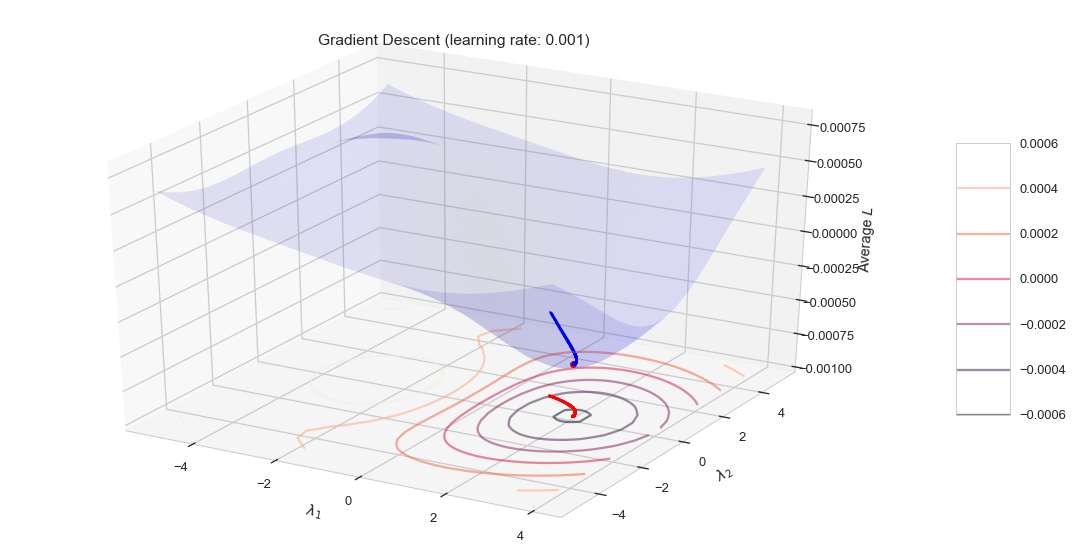

In [14]:
plot_3d_hist(gd.history, gd.costs)
plt.title('Gradient Descent (learning rate: {})'.format(gd.step));

Gradient Descent


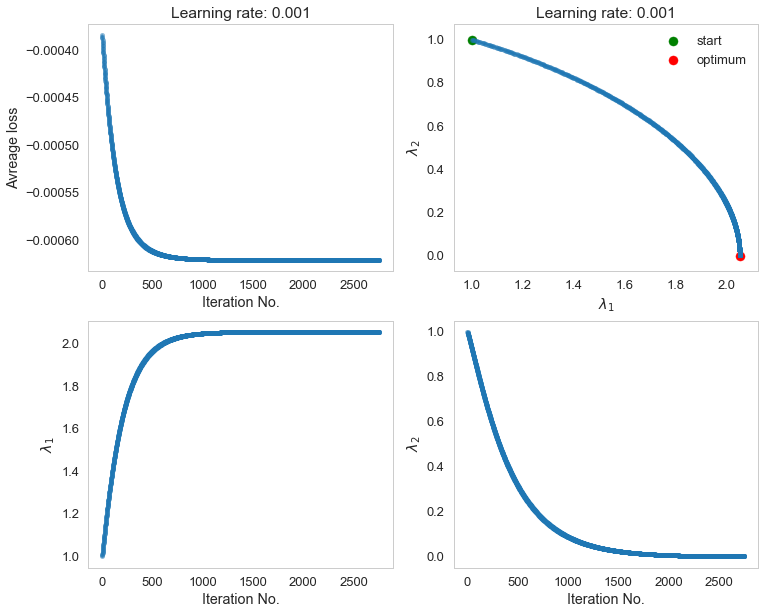

In [15]:
print('Gradient Descent')
plot_summary(gd)

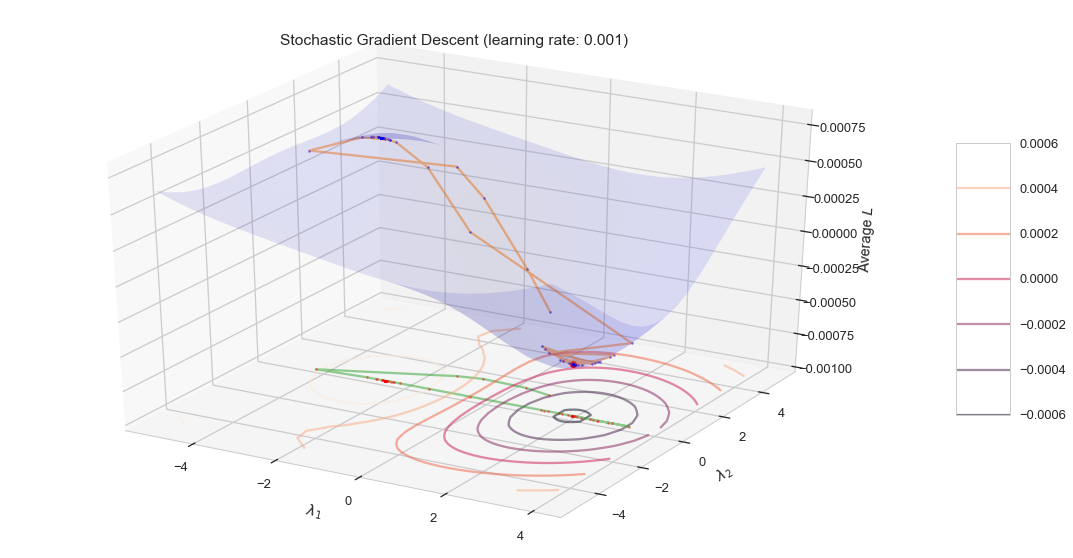

In [16]:
plot_3d_hist(sgd.history, [L(x, y, h) for h in sgd.history])
plt.title('Stochastic Gradient Descent (learning rate: {})'.format(sgd.step));

Stochastic Gradient Descent


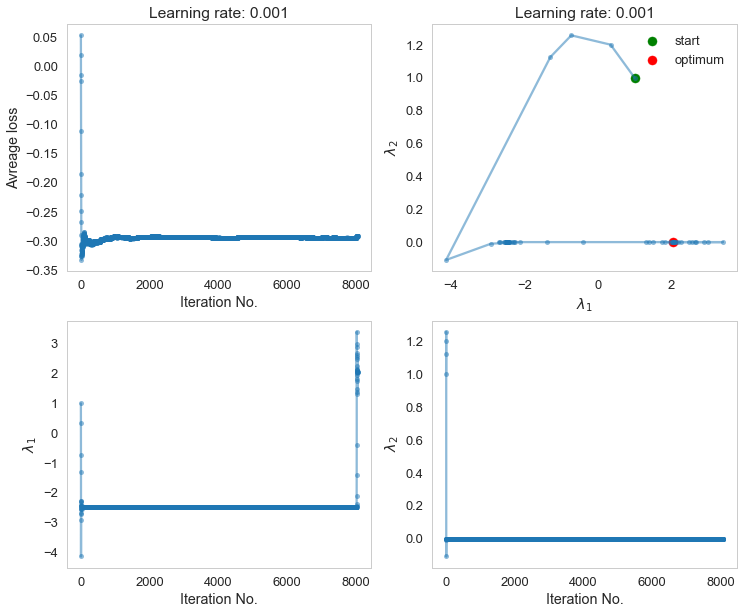

In [17]:
print('Stochastic Gradient Descent')
plot_summary(sgd)

The path GD takes seems much smoother than that SGD takes. While batch gradient ensures GD approaching local optimum in each iteration, SGD takes some detour in "finding" the optimum, which results in more iterations than GD. 

In this case, it seems SGD "bumped into" the optimum we were waiting for rather than finding the optimum. If we don't know the optimum beforehand, SGD might not converge there. SGD usually gets close to the optimum faster than batch method, but never fully converge to the optimum. Also, in this case although SGD takes more iterations than GD, it takes much less computation.

### Answer to Problem 1 Part C

In [18]:
steps = [1, 0.1, 0.001, 0.0001, 0.00001]
sgds = []
for s in steps:
    print('Learning rate: {}.'.format(s))
    sgds.append(SGD(x, y, np.array([1, 1]), step=s, tol=1e-3, max_epoch=5).run_sgd_test())
    print('Number of iterations: {}.'.format(sgds[-1].iter_))
    print('Final lambda: {}'.format(sgds[-1].history[-1]))
    print('L2 distance to the optimum: {}.'.format(np.linalg.norm(sgds[-1].history[-1] - lam_best)))
    print('Average loss along the path: {}.'.format(sgds[-1].costs[-1]))
    print('Average loss on the dataset: {}.'.format(L(x, y, sgds[-1].history[-1])))
    print('----------------')
    print()

Learning rate: 1.


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in double_scalars
  import sys
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in double_scalars
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  


Number of iterations: 80000.
Final lambda: [ nan  nan]
L2 distance to the optimum: nan.
Average loss along the path: nan.
Average loss on the dataset: nan.
----------------

Learning rate: 0.1.
Number of iterations: 80000.
Final lambda: [ nan  nan]
L2 distance to the optimum: nan.
Average loss along the path: nan.
Average loss on the dataset: nan.
----------------

Learning rate: 0.001.
Number of iterations: 8054.
Final lambda: [  2.05364425e+000   6.32404027e-322]
L2 distance to the optimum: 0.0001957475651179763.
Average loss along the path: -0.2918589239125654.
Average loss on the dataset: -0.0006208814949922327.
----------------

Learning rate: 0.0001.
Number of iterations: 8270.
Final lambda: [  2.05287932e+000   7.60692890e-306]
L2 distance to the optimum: 0.00096067954052792.
Average loss along the path: -0.27727466193866285.
Average loss on the dataset: -0.0006208813532968805.
----------------

Learning rate: 1e-05.
Number of iterations: 80000.
Final lambda: [ -5.36324926e+00  

We can visualize the path in each case as follows.

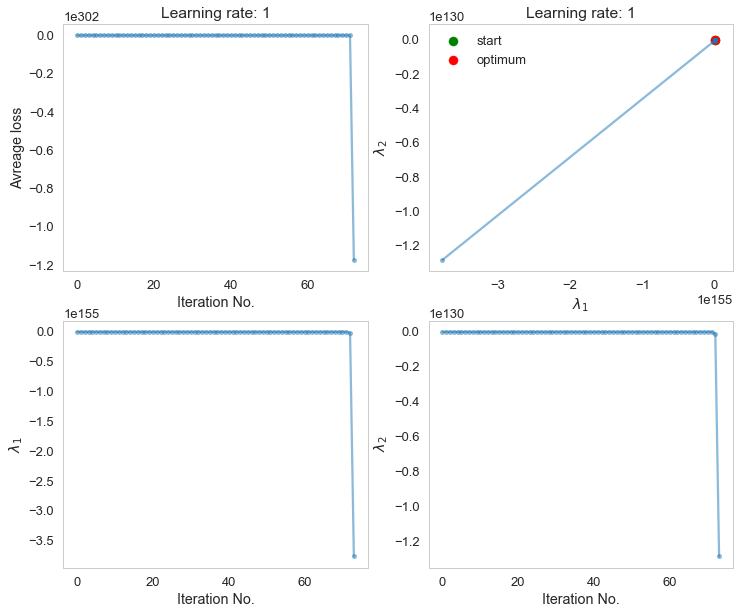

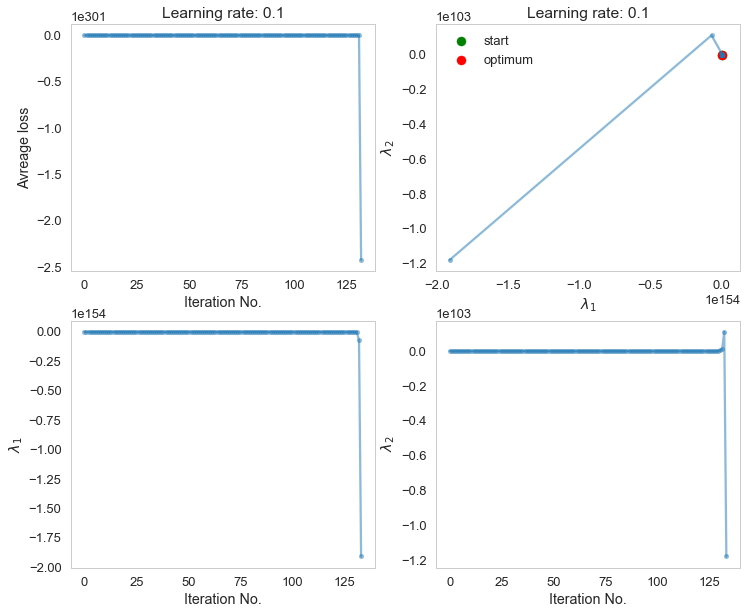

In [19]:
plot_summary(sgds[0])
plot_summary(sgds[1])

As we can see, when we set the learning rate at 1 or 0.1, the update is too large at each step; the loss function and the gradient blow up, and we finally encounter overflow issue.

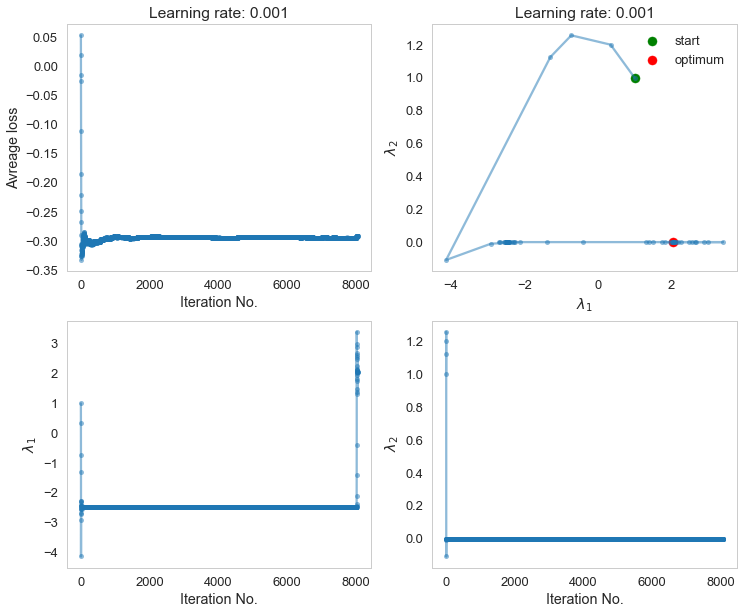

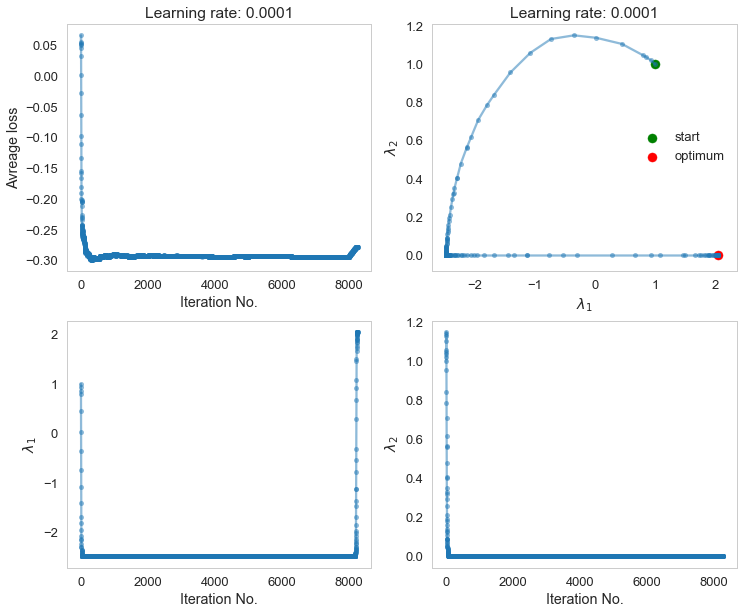

In [20]:
plot_summary(sgds[2])
plot_summary(sgds[3])

When we set the learning rate at 0.001 or 0.0001, we can reach the optimum. The number of iterations corresponding to 0.0001 is slightly larger than that of 0.001.

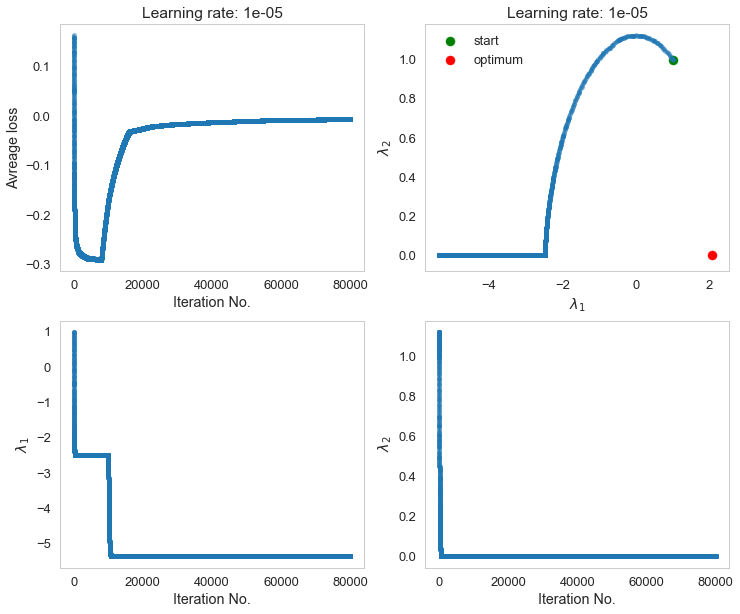

In [21]:
plot_summary(sgds[4])

When we set the learning rate at 0.00001, SGD didn't "find" the optimum when it reaches `max_epoch`; it seems it "converges" to another answer.

In summary, when the learning rate is too large, SGD would take large random steps in each iteration and is likely to blow up and runs into overflow issue.

When the learning rate is neither too large nor too small, SGD could "reach" the optimum although it might not be able to "realize" it without evaluating the batch gradient or loss function. Smaller learning rate would usually take more iterations.

When the learning rate is too small, it takes longer for SGD to converge and SGD might not be able to "reach" the optimum within a fixed amount of iterations.

## Problem 2. SGD for Multinomial Logistic Regression on MNIST

The [*MNIST* dataset](https://en.wikipedia.org/wiki/MNIST_database) is one of the classic datasets in Machine Learning and is often one of the first datasets against which new classification algorithms test themselves.  It consists of 70,000 images of handwritten digits, each of which is 28x28 pixels. You will be using PyTorch to build a handwritten digit classifier that you will train and test with MNIST. 

** The MNIST dataset (including a train/test split which you must use) is part of PyTorch in the torchvision module.  The Lab will have details of how to load it. **

Your classifier must implement a multinomial logistic regression model (using softmax). It will take as input an array of pixel values in an image and output the images most likely digit label (i.e. 0-9). You should think of the pixel values as features of the input vector.  

1. Plot 10 sample images from the MNIST dataset (to develop intuition for the feature space).
2. Construct a softmax formulation in PyTorch of multinomial logistic regression with Cross Entropy Loss.
3. Train your model using SGD to minimize the cost function. *Use a batch size of 64, a learning rate $\eta = 0.01$, and 10 epochs*.
4. Plot the cross-entropy loss on the training set as a function of iteration.
5. What are the training and test set accuracies?  
6. Plot some (around 5) examples of misclassifications.




### Answer to Problem 2

In [2]:
import torch
import torchvision
from torchvision import datasets
from torchvision import transforms
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [3]:
# Load data

transform = transforms.Compose([transforms.ToTensor(), \
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = datasets.MNIST(root='', train=True, download=True, transform=transform)
testset = datasets.MNIST(root='', train=False, transform=transform)


#### 1. Plot 10 sample images from the MNIST dataset

5 0 4 1 9 2 1 3 1 4


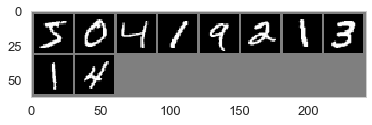

In [4]:
# Reference:
# http://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py

trainloader = torch.utils.data.DataLoader(trainset, batch_size=10, shuffle=False)

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join([str(l) for l in labels]))

#### 2. Construct a softmax formulation in PyTorch of multinomial logistic regression with Cross Entropy Loss.

In [5]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.linear = nn.Linear(28 * 28, 10)
        self.logsoftmax = nn.LogSoftmax(dim=1)
        
    def forward(self, x):
        x = x.view(x.shape[0], 28*28)
        return self.logsoftmax(self.linear(x))

    
class MLR:
    def __init__(self, lr=0.01, max_epoch=10):
        self.max_epoch = max_epoch
        self.model = Model()
        self.criterion = nn.NLLLoss()
        self.optimizer = optim.SGD(self.model.parameters(), lr=lr)
        self.loss_ = []
        
    def fit(self, trainloader):
        for epoch in range(self.max_epoch):
            running_loss = 0
            for i, data in enumerate(trainloader, 0):
                inputs, labels = data
                inputs, labels = Variable(inputs), Variable(labels)
                self.optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()
                running_loss += loss.data[0]
                self.loss_.append(loss.data[0])
            print('Epoch {} loss: {}'.format(epoch + 1, running_loss / len(trainloader)))
        print('Finished Training.')
        return self

    def predict(self, x):
        outputs = self.model(Variable(deepcopy(x)))
        _, pred = torch.max(outputs.data, 1)
        return pred
    
def getData(testloader):
    return iter(testloader).next()        

#### 3. Train your model using SGD to minimize the cost function. *Use a batch size of 64, a learning rate $\eta = 0.01$, and 10 epochs*.

In [6]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
trainloader2 = torch.utils.data.DataLoader(trainset, batch_size=60000, shuffle=False)
testloader = torch.utils.data.DataLoader(testset, batch_size=10000, shuffle=False)

mlr = MLR(lr=0.01, max_epoch=10).fit(trainloader)

Epoch 1 loss: 0.6085820051112663
Epoch 2 loss: 0.3873185949729704
Epoch 3 loss: 0.35267389373484453
Epoch 4 loss: 0.3349054019842575
Epoch 5 loss: 0.3236767000067971
Epoch 6 loss: 0.3159288539370494
Epoch 7 loss: 0.30913406163295193
Epoch 8 loss: 0.30494309202440256
Epoch 9 loss: 0.30115880849741417
Epoch 10 loss: 0.2975056896220519
Finished Training.


#### 4. Plot the cross-entropy loss on the training set as a function of iteration.

We can plot the loss at each step, as well as average cross-entropy loss after each iteration as follows.

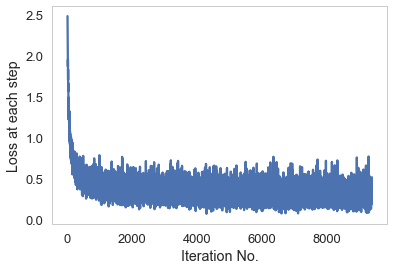

In [7]:
plt.plot(np.arange(1, len(mlr.loss_) + 1), mlr.loss_);
plt.xlabel('Iteration No.');
plt.ylabel('Loss at each step');

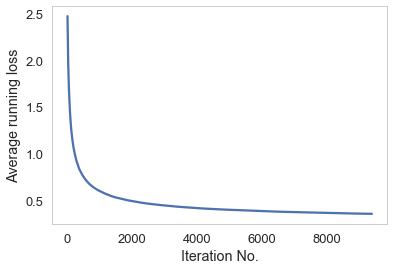

In [8]:
mean_loss = np.cumsum(mlr.loss_) / np.arange(1, len(mlr.loss_) + 1)
plt.plot(np.arange(1, len(mean_loss) + 1), mean_loss);
plt.xlabel('Iteration No.');
plt.ylabel('Average running loss');

#### 5. What are the training and test set accuracies?

In [9]:
def accuracy_score(y_true, y_pred, verbose=False):
    if not verbose:
        return np.mean(y_true == y_pred)
    else:
        return np.array([np.mean(y_pred_test[y_test == i] == i) for i in range(10)])

In [10]:
x_train, y_train = getData(trainloader2)
x_test, y_test = getData(testloader)

In [11]:
y_pred_train = mlr.predict(x_train)
y_pred_test = mlr.predict(x_test)

accu_train = accuracy_score(y_train, y_pred_train, verbose=True)
accu_test = accuracy_score(y_test, y_pred_test, verbose=True)

print('Training set:')
print('Overall accuracy : {:.4f}'.format(accuracy_score(y_train, y_pred_train)))
for i in range(10):
    print('Accuracy of {} : {:.4f}'.format(i, accu_train[i]))

print('----------------')
print()

print('Test set:')
print('Overall accuracy : {:.4f}'.format(accuracy_score(y_test, y_pred_test)))
for i in range(10):
    print('Accuracy of {} : {:.4f}'.format(i, accu_test[i]))

Training set:
Overall accuracy : 0.9162
Accuracy of 0 : 0.9755
Accuracy of 1 : 0.9771
Accuracy of 2 : 0.8769
Accuracy of 3 : 0.9139
Accuracy of 4 : 0.9257
Accuracy of 5 : 0.8296
Accuracy of 6 : 0.9614
Accuracy of 7 : 0.9105
Accuracy of 8 : 0.9138
Accuracy of 9 : 0.8940
----------------

Test set:
Overall accuracy : 0.9191
Accuracy of 0 : 0.9755
Accuracy of 1 : 0.9771
Accuracy of 2 : 0.8769
Accuracy of 3 : 0.9139
Accuracy of 4 : 0.9257
Accuracy of 5 : 0.8296
Accuracy of 6 : 0.9614
Accuracy of 7 : 0.9105
Accuracy of 8 : 0.9138
Accuracy of 9 : 0.8940


#### 6. Plot some (around 5) examples of misclassifications.

Actual labels: 
5 4 3 2 9 7 7 2

Predicted labels: 
6 6 2 7 4 1 4 9


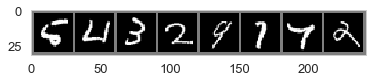

In [12]:
imshow(torchvision.utils.make_grid(x_test[[np.where(y_test != y_pred_test)[0][:8]]]))
print('Actual labels: \n' + ' '.join([str(l) for l in y_test[y_test != y_pred_test][:8]]))
print()
print('Predicted labels: \n' + ' '.join([str(l) for l in y_pred_test[y_test != y_pred_test][:8]]))